## Simulation of dual phosphorylation-dephosphorylation cycle using Spatiocyte and ODE solver

In [19]:
import math
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
from ecell4 import *
rng = GSLRandomNumberGenerator()

### Dual phosphorylation-dephosphorylation model and parameters

In [20]:
@species_attributes
def attrgen(radius, D):
    K | {"radius": radius, "D": D}
    Kp | {"radius": radius, "D": D}
    Kpp | {"radius": radius, "D": D}
    KK | {"radius": radius, "D": D}
    PP | {"radius": radius, "D": D}
    K_KK | {"radius": radius, "D": D}
    Kp_KK | {"radius": radius, "D": D}
    Kpp_PP | {"radius": radius, "D": D}
    Kp_PP | {"radius": radius, "D": D}
    C | {"radius": radius, "D": D}

@reaction_rules
def rulegen(kon1, koff1, kcat1, kon2, koff2, kcat2,k7):
    (KK + K == K_KK | (kon1, koff1)
        > Kp + KKa | kcat1)
    (KK + Kp == Kp_KK | (kon2, koff2)
        > Kpp + KKa | kcat2)
    (KKa > KK | k7)
    (Kpp + PP == Kpp_PP | (kon1, koff1)
        > Kp + PPa | kcat1)     
    (Kp + PP == Kp_PP | (kon2, koff2)
        > K + PPa | kcat2)
    (PPa > PP | k7)

@reaction_rules    
def rulegen2(kon1, koff1, kcat1, kcat2):
    (K + KK == K_KK | (kon1, koff1)
        > Kp_KK | kcat1
        > Kpp + KK | kcat2)

    (Kpp + PP == Kpp_PP | (kon1, koff1)
        > Kp + PP | kcat1
        > K + PP | kcat2)

ka1, kd1, kcat1 = 0.04483455086786913, 1.35, 1.5
ka2, kd2, kcat2 = 0.09299017957780264, 1.73, 15.0
trel = 1e-3#1e-6
k7 = math.log(2)/trel
radius = 0.0025

### Simulator for Spatiocyte and ODE

In [21]:
def run(ratio,m,dur,NKT,NK): #Spatiocyte simulator
    voxelr = 1.0208582*radius
    w = spatiocyte.SpatiocyteWorld(Real3(1, 1, 1),voxelr,rng)
    w.bind_to(m)
    w.add_molecules(Species("K"), NK)
    w.add_molecules(Species("Kpp"), NKT-NK)
    Nppkk=int(60)
    npp = int(Nppkk/(ratio+1))
    nkk = Nppkk-npp
    w.add_molecules(Species("KK"), nkk)
    w.add_molecules(Species("PP"), npp)
    sim = spatiocyte.SpatiocyteSimulator(m, w)
    obs = FixedIntervalNumberObserver(1.0, ["KK","Kpp","PP"])
    sim.run(dur, [obs])
    data = np.array(obs.data()).T
    NKK = data[1]
    NKpp = data[2]
    NP = data[3]
    tt = data[0]
    return tt,NKK,NKpp,NP

def run_ode(ratio,m,dur,NKT,NK): #ODE simulator
    w = ode.ODEWorld(Real3(1, 1, 1))
    w.bind_to(m)
    w.add_molecules(Species("K"), NK)
    w.add_molecules(Species("Kpp"), NKT-NK)
    Nppkk=int(60)
    npp = int(Nppkk/(ratio+1))
    nkk = Nppkk-npp
    w.add_molecules(Species("KK"), nkk)
    w.add_molecules(Species("PP"), npp)
    sim = ode.ODESimulator(m,w)#simulator_type(m, w)
    obs = FixedIntervalNumberObserver(1.0, ["KK","Kpp","PP"])
    sim.run(dur, [obs])
    data = np.array(obs.data()).T
    NKK = data[1]
    NKpp = data[2]
    NP = data[3]
    tt = data[0]
    return tt,NKK,NKpp,NP

### Execute simulation

In [22]:
#spatiocyte simulator
ratios = np.logspace(-1.5,1.5,12)
NK= int(120*5)
NKT=int(120*5)
dur = 100 #duration
D=0.06

m = NetworkModel()
voxelr = 1.0208582*radius
for i, sp in enumerate(attrgen(str(voxelr), str(D))):
    m.add_species_attribute(sp)
rul = rulegen(ka1, kd1, kcat1, ka2, kd2, kcat2,k7)
for i, rr in enumerate(rul):
    reactants, products, k = rr.reactants(), rr.products(), rr.k()
    m.add_reaction_rule(rr)
xx = []
yy = []    
ratio=0.9
tt,NKK,NKpp,NP = run(ratio,m,dur,NKT,NK)
out=NKpp/NKT

#xx.append(ratio) #[kk]/[P]
#yy.append(np.mean(NKpp[int(dur*0.5):])/NKT) #[Kpp]/[K]total


0.30019047619047623

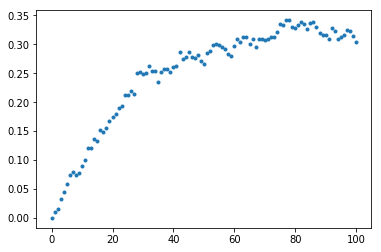

In [23]:
plt.plot(tt,out,'.')
idx=tt>30
np.mean(out[idx])

### Load and plot data used in the paper

In [24]:
#ode solver
ratios = np.logspace(np.log10(0.4),np.log10(4.),10)
NK= int(120*5)
NKT=int(120*5)
dur = 100
xx = [[],[]]
yy = [[],[]]
D=4.
m = NetworkModel()
for i, sp in enumerate(attrgen(str(radius), str(D))):
    m.add_species_attribute(sp)
def kon(k):
    kD = 4*3.14*2*radius*2*D
    return k*kD/(k+kD)
def koff(kd,ka):
    return kon(ka)*kd/ka 
rul = rulegen(kon(ka1), koff(kd1,ka1), kcat1, kon(ka2), koff(kd2,ka2), kcat2,k7)    
lab = 'distributive'

for i, rr in enumerate(rul):
    reactants, products, k = rr.reactants(), rr.products(), rr.k()
    m.add_reaction_rule(rr)

for idx,NK in enumerate([0,NKT]):
    for ratio in ratios:
        tt,NKK,NKpp,NP = run_ode(ratio,m,dur,NKT,NK)
        xx[idx].append(ratio) #[kk]/[P]
        yy[idx].append(np.mean(NKpp[int(dur*0.5):])/NKT) #[Kpp]/[K]total

save=1       
if save==1:
    name='data/MAPK_ODE_dist_bistable_frm_above'
    f=open(name,'w')
    np.savetxt(name,np.column_stack([xx[0],yy[0]]),delimiter=',')
    f.close()   
    name='data/MAPK_ODE_dist_bistable_frm_bottom'
    f=open(name,'w')
    np.savetxt(name,np.column_stack([xx[1],yy[1]]),delimiter=',')
    f.close()     
    

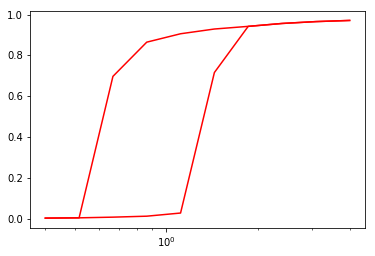

In [25]:
plt.semilogx(xx[0],yy[0],'r-')
plt.semilogx(xx[1],yy[1],'r-')

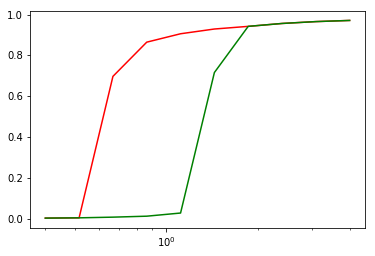

In [26]:
name='data/MAPK_ODE_dist_bistable_frm_above'
dat=np.genfromtxt(name,delimiter=',').T
X=dat[0]
Y=dat[1]
plt.semilogx(X,Y,'r-')
name='data/MAPK_ODE_dist_bistable_frm_bottom'
dat=np.genfromtxt(name,delimiter=',').T
X=dat[0]
Y=dat[1]
plt.semilogx(X,Y,'g-')
